In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split #pip install sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the dataset

In [ ]:
# https://quickdraw.withgoogle.com/data
dataset_dir = "/content/drive/My Drive/quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)

# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size=0.33)

print("images_train.shape", images.shape)
print("targets_train.shape", targets.shape)

print("images_test.shape", images_test.shape)
print("targets_test.shape", targets_test.shape)

print(draw_class)

images_train.shape (15000, 28, 28)
targets_train.shape (15000,)
images_test.shape (4950, 28, 28)
targets_test.shape (4950,)
['airplane', 'apple', 'book', 'brain', 'car', 'chair', 'dog', 'eye', 'The Eiffel Tower', 'face']


## Plot exemples of images

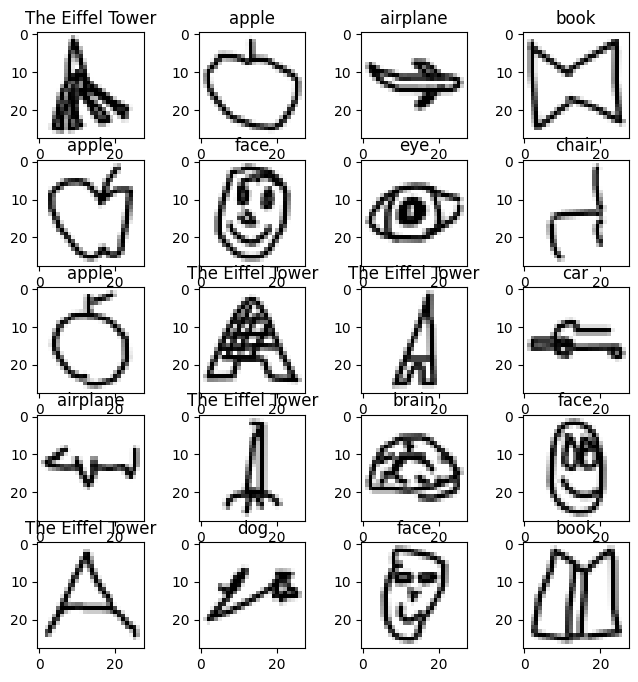

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])])
    plt.imshow(img, cmap="gray")
plt.show()

## Normalization

In [ ]:
print("Mean and std of images", images_train.mean(), images_train.std())
scaler = StandardScaler()
scaled_images_train = scaler.fit_transform(images_train.reshape(-1, 28*28))
scaled_images_test = scaler.fit_transform(images_test.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images_train.mean(), scaled_images_train.std())

scaled_images_train = scaled_images_train.reshape(-1, 28, 28, 1)
scaled_images_test = scaled_images_test.reshape(-1, 28, 28, 1)

Mean and std of images 209.63011 85.086075
Mean and std of scaled images 2.3239095e-11 0.92857134


# Build a CNN model

In [ ]:
model = tf.keras.models.Sequential()
# Convolutions
model.add(tf.keras.layers.Conv2D(32, 4, activation='relu'))
#"valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input.
#When padding="same" and strides=1, the output has the same size as the input.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
# Flatten the convolution
model.add(tf.keras.layers.Flatten())
# Dense layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


model.predict(scaled_images_train[0:1])

1/1 [==============================] - 0s 284ms/step


array([[0.10794916, 0.12524076, 0.08798705, 0.10061298, 0.13735585,
        0.10743051, 0.07041717, 0.112147  , 0.06424015, 0.08661935]],
      dtype=float32)

## Set the loss and objectives

In [ ]:
# Compile the model


opt = Adam(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5 )
history = model.fit(scaled_images_train, targets_train, epochs=10, validation_split=0.2, batch_size=64, callbacks=[es])

Epoch 1/10
126/126 [==============================] - 79s 616ms/step - loss: 1.0549 - accuracy: 0.6657 - val_loss: 0.4905 - val_accuracy: 0.8562
Epoch 2/10
126/126 [==============================] - 77s 605ms/step - loss: 0.5579 - accuracy: 0.8254 - val_loss: 0.3746 - val_accuracy: 0.8841
Epoch 3/10
126/126 [==============================] - 73s 578ms/step - loss: 0.4382 - accuracy: 0.8644 - val_loss: 0.3448 - val_accuracy: 0.8920
Epoch 4/10
126/126 [==============================] - 73s 580ms/step - loss: 0.3668 - accuracy: 0.8818 - val_loss: 0.3194 - val_accuracy: 0.9010
Epoch 5/10
126/126 [==============================] - 73s 578ms/step - loss: 0.3330 - accuracy: 0.8969 - val_loss: 0.3217 - val_accuracy: 0.9045
Epoch 6/10
126/126 [==============================] - 73s 579ms/step - loss: 0.2601 - accuracy: 0.9160 - val_loss: 0.3211 - val_accuracy: 0.9025
Epoch 7/10
126/126 [==============================] - 73s 578ms/step - loss: 0.2381 - accuracy: 0.9203 - val_loss: 0.3197 - val_ac

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 21, 21, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 19, 19, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 18, 18, 128)     

## Set some metrics to track the progress of the training

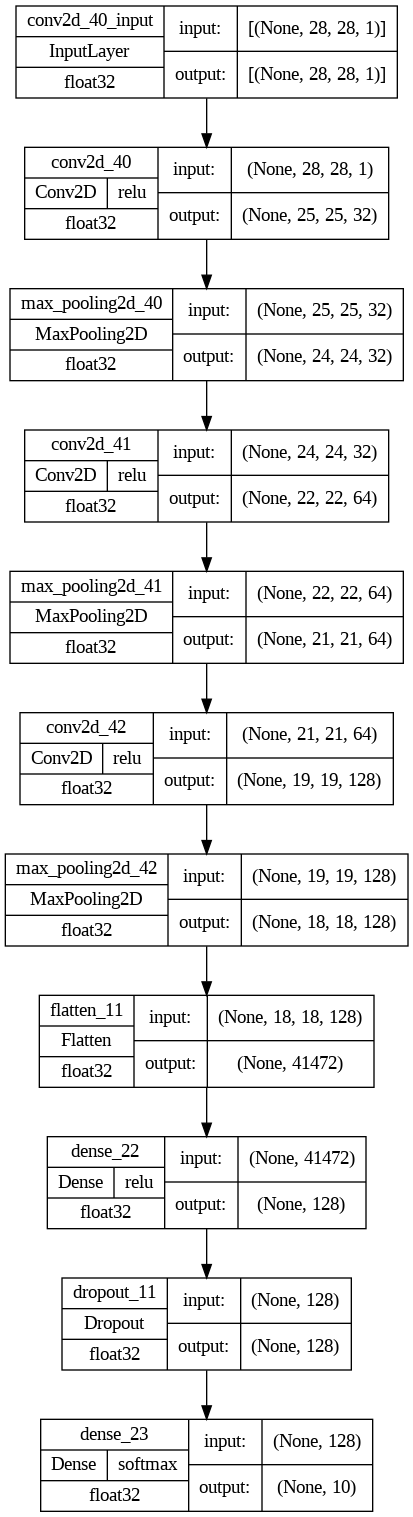

In [ ]:
tf.keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

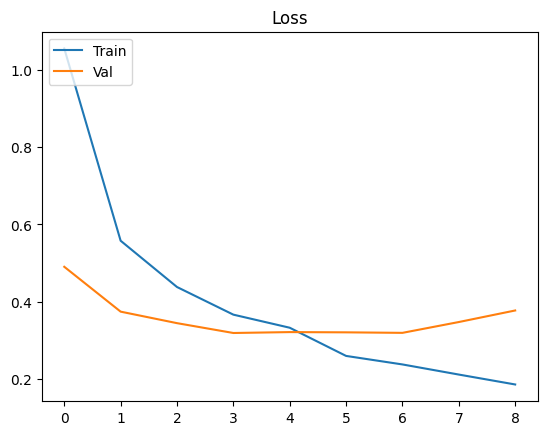

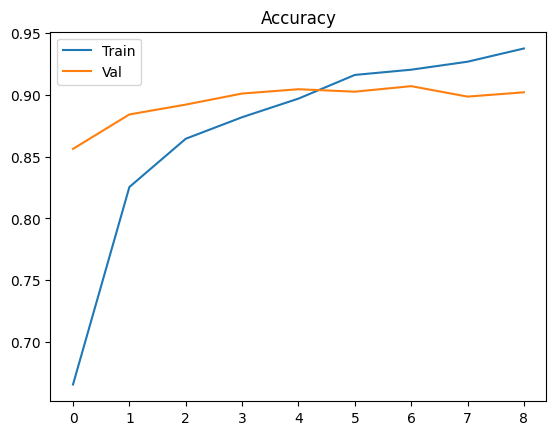

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

# test the model

In [ ]:
loss, acc = model.evaluate(scaled_images_test, targets_test)
print("Test loss", loss)
print("Train accuracy", acc)

155/155 [==============================] - 11s 73ms/step - loss: 0.3980 - accuracy: 0.8996
Test loss 0.39797091484069824
Train accuracy 0.8995959758758545


### Exercice

1. Build a more complicated model with the following pattern:
- Conv -> MaxPool -> Conv -> MaxPool -> Conv -> MaxPool -> Conv -> MaxPool ->(Flatten) -> Dense -> Final Classification

- Use strides of 2 for all convolutional layers.

2. How many parameters does your model have?  

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers ?

5. Try different structures and run times, and see how accurate your model can be.

In [ ]:
#1st question

model2 = tf.keras.models.Sequential()

# Convolutions
model2.add(tf.keras.layers.Conv2D(32, 4, strides=2, padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model2.add(tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model2.add(tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model2.add(tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'))

# Flatten the convolution
model2.add(tf.keras.layers.Flatten())

# Dense layers
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

# Assuming scaled_images_train is your input data
model2.predict(scaled_images_train[0:1])




1/1 [==============================] - 0s 234ms/step


array([[0.10069664, 0.09892733, 0.10287941, 0.0999666 , 0.09929752,
        0.09986405, 0.09938303, 0.09905817, 0.0998331 , 0.10009413]],
      dtype=float32)

In [ ]:
#2nd question : number of parameters
model2.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 14, 14, 32)        544       
                                                                 
 max_pooling2d_98 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 2, 2, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 1, 1, 128)         73856     
                                                                 
 max_pooling2d_100 (MaxPool  (None, 1, 1, 128)       

In [ ]:
# Compile the model2


opt = Adam(learning_rate=0.001)
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [ ]:
#3rd question: training the model for 5 epochs


In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5 )
history = model2.fit(scaled_images_train, targets_train, epochs=5, validation_split=0.2, batch_size=64, callbacks=[es])

Epoch 1/5
126/126 [==============================] - 5s 31ms/step - loss: 1.5707 - accuracy: 0.4377 - val_loss: 0.9560 - val_accuracy: 0.6871
Epoch 2/5
126/126 [==============================] - 4s 30ms/step - loss: 0.9084 - accuracy: 0.7015 - val_loss: 0.6849 - val_accuracy: 0.7945
Epoch 3/5
126/126 [==============================] - 5s 42ms/step - loss: 0.7200 - accuracy: 0.7688 - val_loss: 0.5688 - val_accuracy: 0.8139
Epoch 4/5
126/126 [==============================] - 4s 29ms/step - loss: 0.6021 - accuracy: 0.8108 - val_loss: 0.5519 - val_accuracy: 0.8234
Epoch 5/5
126/126 [==============================] - 4s 29ms/step - loss: 0.5270 - accuracy: 0.8368 - val_loss: 0.5034 - val_accuracy: 0.8373
